In [81]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import scipy
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns


In [82]:
# dir for mac

sst_file_dir = "/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/OISST/northeast_sst.nc"
prec_file_dir = "/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/TRMM/northeast_precip.nc"

In [83]:
sst_oisst = xr.open_dataarray(sst_file_dir)

sst_oisst = sst_oisst.loc[0: 8034,:, :]

precip = xr.open_dataarray(prec_file_dir)

In [84]:
sst_oisst

<xarray.DataArray 'sst' (time: 8034, lat: 122, lon: 122)>
[119578056 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -40.12 -39.88 -39.62 -39.38 ... -10.38 -10.12 -9.875
  * lon      (lon) float64 139.9 140.1 140.4 140.6 ... 169.4 169.6 169.9 170.1
  * time     (time) float64 1.0 2.0 3.0 4.0 ... 8.032e+03 8.033e+03 8.034e+03

In [85]:
date_time = pd.date_range(start='1998-01-01', periods=8034, freq='D')



In [86]:
sst_oisst['time'] = date_time

precip['time'] = date_time

In [87]:
precip_box_01 = precip.sel(lat=slice(-30,-27), lon=slice(154,157))


sst_oisst_box_01 = sst_oisst.sel(lat=slice(-30,-27), lon=slice(154,157))

In [ ]:
precip_box_02 = precip.sel(lat=slice(-30,-27), lon=slice(160,163))

sst_oisst_box_02 = sst_oisst.sel(lat=slice(-30,-27), lon=slice(160,163))

In [89]:
precip_box_03 = precip.sel(lat=slice(-30,-27), lon=slice(167,170))

sst_oisst_box_03 = sst_oisst.sel(lat=slice(-30,-27), lon=slice(167,170))

In [90]:
precip_box_01_values = precip_box_01.values.reshape(8034*12*12)

precip_box_01_values_log = np.log1p(precip_box_01_values)

sst_oisst_box_01_values = sst_oisst_box_01.values.reshape(8034*12*12)


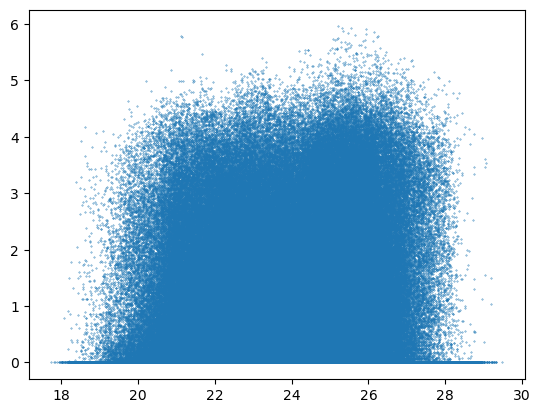

In [91]:
plt.scatter(sst_oisst_box_01_values, precip_box_01_values_log, s=0.1)

In [92]:
def precip_accumulation_on_sst(data, sst_interval, sst_min, sst_max):
    """
    Calculate the accumulation of precipitation on a certain range of sea surface temperature (SST) values.
    data: Pandas DataFrame with columns 'sst' and 'precip'
    """
    # Create bins for SST values
    sst_bins = np.arange(sst_min, sst_max, sst_interval)
    bin_labels = [f'({bin_edge:.1f}, {bin_edge+1:.1f})' for bin_edge in sst_bins[:-1]]
    data['SST_bin'] = pd.cut(data['SST'], bins=sst_bins,right = False, labels=bin_labels)
    accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()
    accumulated_precip['bin_midpoint'] = [bin_edge + 0.5 for bin_edge in range(sst_min, sst_max-1)]
    print("Accumulated Precipitation by SST Bin:")
    print(accumulated_precip)
    
    return accumulated_precip, bin_labels, sst_bins

In [93]:
def bar_plot(accumulated_precip, bin_labels,box_name):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
        width=0.8, edgecolor='black', linewidth=1)
    # Add data labels above each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 * height,
                f'{height:.1f}',
                ha='center', va='bottom', rotation=0, fontsize=10)

    plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
    plt.ylabel('Accumulated Precipitation', fontsize=14)
    plt.title('Total Accumulated Precipitation by SST Range_' + box_name , fontsize=16)
    plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
    plt.tight_layout()
    plt.show()

    # Create a line plot to show the trend more clearly
    plt.figure(figsize=(12, 6))
    plt.plot(accumulated_precip['bin_midpoint'], accumulated_precip['Precipitation'], 
            marker='o', markersize=10, linewidth=2, color='royalblue')

    # Add data labels to each point
    for i, val in enumerate(accumulated_precip['Precipitation']):
        plt.text(accumulated_precip['bin_midpoint'][i], val + 0.05 * val, 
                f'{val:.1f}', ha='center', va='bottom', fontsize=10)

    plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
    plt.ylabel('Accumulated Precipitation', fontsize=14)
    plt.title('Total Accumulated Precipitation by SST Range (Trend)_' + box_name, fontsize=16)
    plt.xticks(accumulated_precip['bin_midpoint'], bin_labels, rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [94]:
def statistical_analysis_plot(data, accumulated_precip,sst_bin, box_name):
    bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
        ('sum', 'sum'),              # Total accumulated precipitation
        ('mean', 'mean'),            # Average precipitation per data point in bin
        ('count', 'count'),          # Number of data points in bin
        ('max', 'max'),              # Maximum precipitation in bin
        ('std', np.std)              # Standard deviation of precipitation in bin
    ]).reset_index()

    # Display the detailed statistics
    print("\nDetailed Statistics for Each SST Bin:")
    print(bin_stats)

        
    # Create a multi-plot figure showing different aspects of the data
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

    # Plot 1: Accumulated precipitation
    axes[0].bar(bin_stats['SST_bin'], bin_stats['sum'], 
            width=0.7, color='royalblue', edgecolor='black', alpha=0.7)
    axes[0].set_ylabel('Accumulated Precipitation', fontsize=12)
    axes[0].set_title('Total Accumulated Precipitation by SST Range_'+box_name, fontsize=14)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Count of data points in each bin
    axes[1].bar(bin_stats['SST_bin'], bin_stats['count'], 
            width=0.7, color='green', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Sea Surface Temperature Range (°C)', fontsize=12)
    axes[1].set_ylabel('Count of Data Points', fontsize=12)
    axes[1].set_title('Number of Observations in Each SST Range_'+box_name, fontsize=14)
    axes[1].set_xticklabels(bin_stats['SST_bin'], rotation=45)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Create a stacked visualization: Precipitation vs SST with bin coloring
    plt.figure(figsize=(14, 8))

    # Create a scatter plot with points colored by SST bin
    # Convert bin labels to numeric for coloring
    unique_bins = data['SST_bin'].unique()
    bin_to_number = {bin_label: i for i, bin_label in enumerate(unique_bins)}
    data['bin_number'] = data['SST_bin'].map(bin_to_number)

    # Scatter plot colored by bin
    scatter = plt.scatter(data['SST'], data['Precipitation'], 
                        c=data['bin_number'], cmap='viridis', 
                        alpha=0.6, s=50, edgecolors='none')

    # Add vertical lines to show bin boundaries
    for bin_edge in sst_bins:
        plt.axvline(x=bin_edge, color='gray', linestyle='--', alpha=0.5)

    # Add legend for the bins
    legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                        labels=unique_bins,
                        title="SST Bins",
                        loc="upper left",
                        bbox_to_anchor=(1.01, 1))
    plt.gca().add_artist(legend1)

    plt.xlabel('Sea Surface Temperature (°C)', fontsize=14)
    plt.ylabel('Precipitation', fontsize=14)
    plt.title('Precipitation Distribution by SST with Binning_'+box_name, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Calculate the proportion of total precipitation that falls in each SST bin
    total_precip = bin_stats['sum'].sum()
    bin_stats['percentage'] = (bin_stats['sum'] / total_precip) * 100


    # Normalized precipitation by count (average precipitation per observation in each bin)
    plt.figure(figsize=(12, 6))
    plt.bar(bin_stats['SST_bin'], bin_stats['mean'], 
        width=0.7, color='purple', edgecolor='black', alpha=0.7)
    plt.ylim(0, 2)
    plt.xlabel('Sea Surface Temperature Range (°C)', fontsize=14)
    plt.ylabel('Average Precipitation per Observation', fontsize=14)
    plt.title('Average Precipitation by SST Range_'+box_name, fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    slope, intercept, r_value, p_value, std_err = stats.linregress(accumulated_precip['bin_midpoint'], bin_stats['mean'])

    regression_line = slope * accumulated_precip['bin_midpoint'] + intercept 
    plt.plot(bin_stats['SST_bin'], regression_line, color='red', label='Linear Regression')
    stats_text = (f'Linear Regression Statistics:\n'
                f'Slope: {slope:.4f}\n'
                f'Intercept: {intercept:.4f}\n'
                f'R-squared: {r_value**2:.4f}\n'
                f'P-value: {p_value:.4f}\n'
                f'Standard Error: {std_err:.4f}')

    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


    plt.show()

In [95]:
precip_box_01_values = precip_box_01.values.reshape(8034*12*12)

precip_box_01_values_log = np.log1p(precip_box_01_values)

sst_oisst_box_01_values = sst_oisst_box_01.values.reshape(8034*12*12)

data_box_01 = pd.DataFrame({'SST': sst_oisst_box_01_values, 'Precipitation': precip_box_01_values_log})

In [105]:
accumulated_precip_box_01, bin_labels, sst_bins = precip_accumulation_on_sst(data_box_01, 1, 19, 29)

Accumulated Precipitation by SST Bin:
        SST_bin  Precipitation  bin_midpoint
0  (19.0, 20.0)    4650.622079          19.5
1  (20.0, 21.0)   21754.781395          20.5
2  (21.0, 22.0)   48323.342507          21.5
3  (22.0, 23.0)   61813.461031          22.5
4  (23.0, 24.0)   62740.654953          23.5
5  (24.0, 25.0)   79054.376542          24.5
6  (25.0, 26.0)   93423.539316          25.5
7  (26.0, 27.0)   50767.744229          26.5
8  (27.0, 28.0)   13615.211763          27.5


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/1117865337.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()


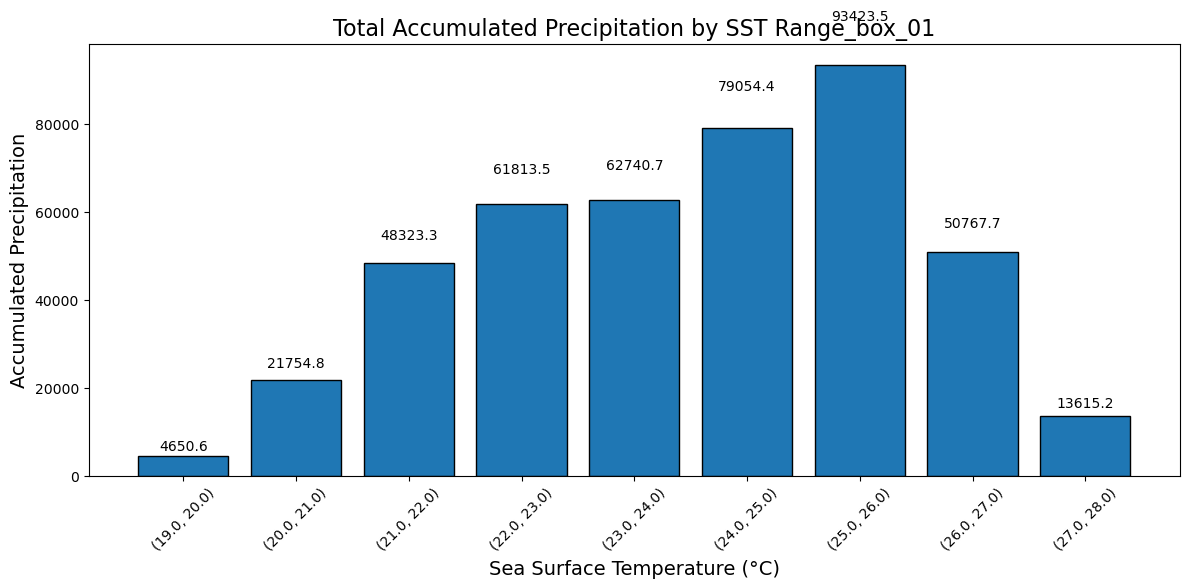

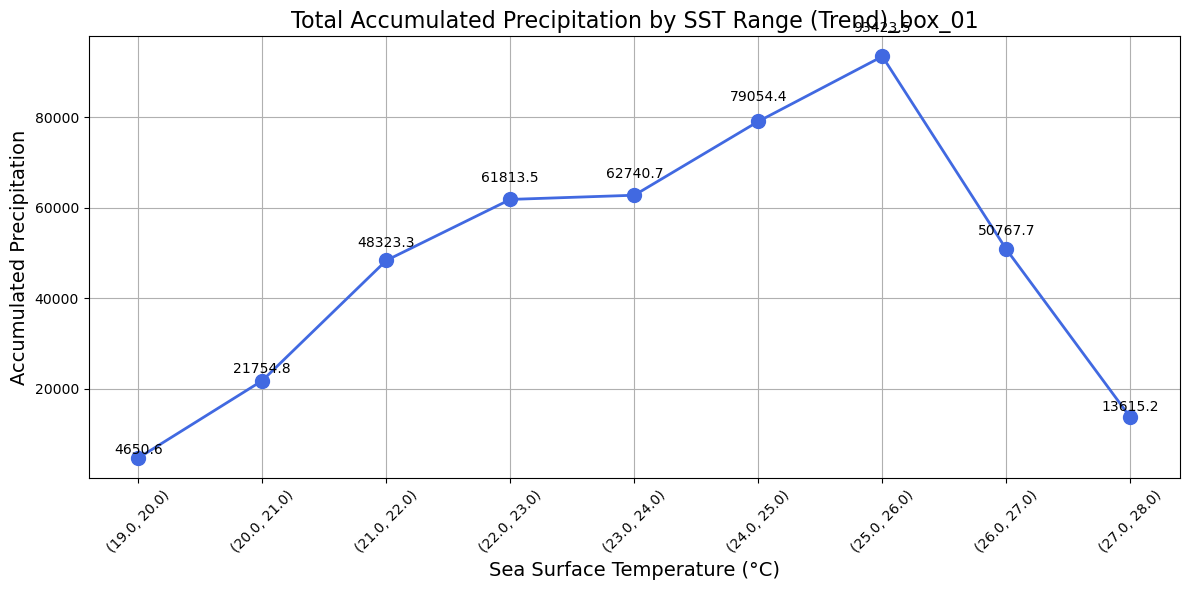

In [106]:
bar_plot(accumulated_precip_box_01, bin_labels, 'box_01')


Detailed Statistics for Each SST Bin:
        SST_bin           sum      mean   count       max       std
0  (19.0, 20.0)   4650.622079  0.172693   26930  4.636475  0.581938
1  (20.0, 21.0)  21754.781395  0.205464  105881  5.188000  0.647897
2  (21.0, 22.0)  48323.342507  0.252933  191052  5.793654  0.722449
3  (22.0, 23.0)  61813.461031  0.324041  190758  5.275663  0.808617
4  (23.0, 24.0)  62740.654953  0.379281  165420  5.405916  0.870540
5  (24.0, 25.0)  79054.376542  0.442319  178727  5.545100  0.935434
6  (25.0, 26.0)  93423.539316  0.524551  178102  5.957714  1.027768
7  (26.0, 27.0)  50767.744229  0.540894   93859  5.855767  1.065212
8  (27.0, 28.0)  13615.211763  0.619070   21993  5.365938  1.140027


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/3989876577.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/3989876577.py:2: FutureWarning: The provided callable <function std at 0x104b28040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/3989876577.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bin_

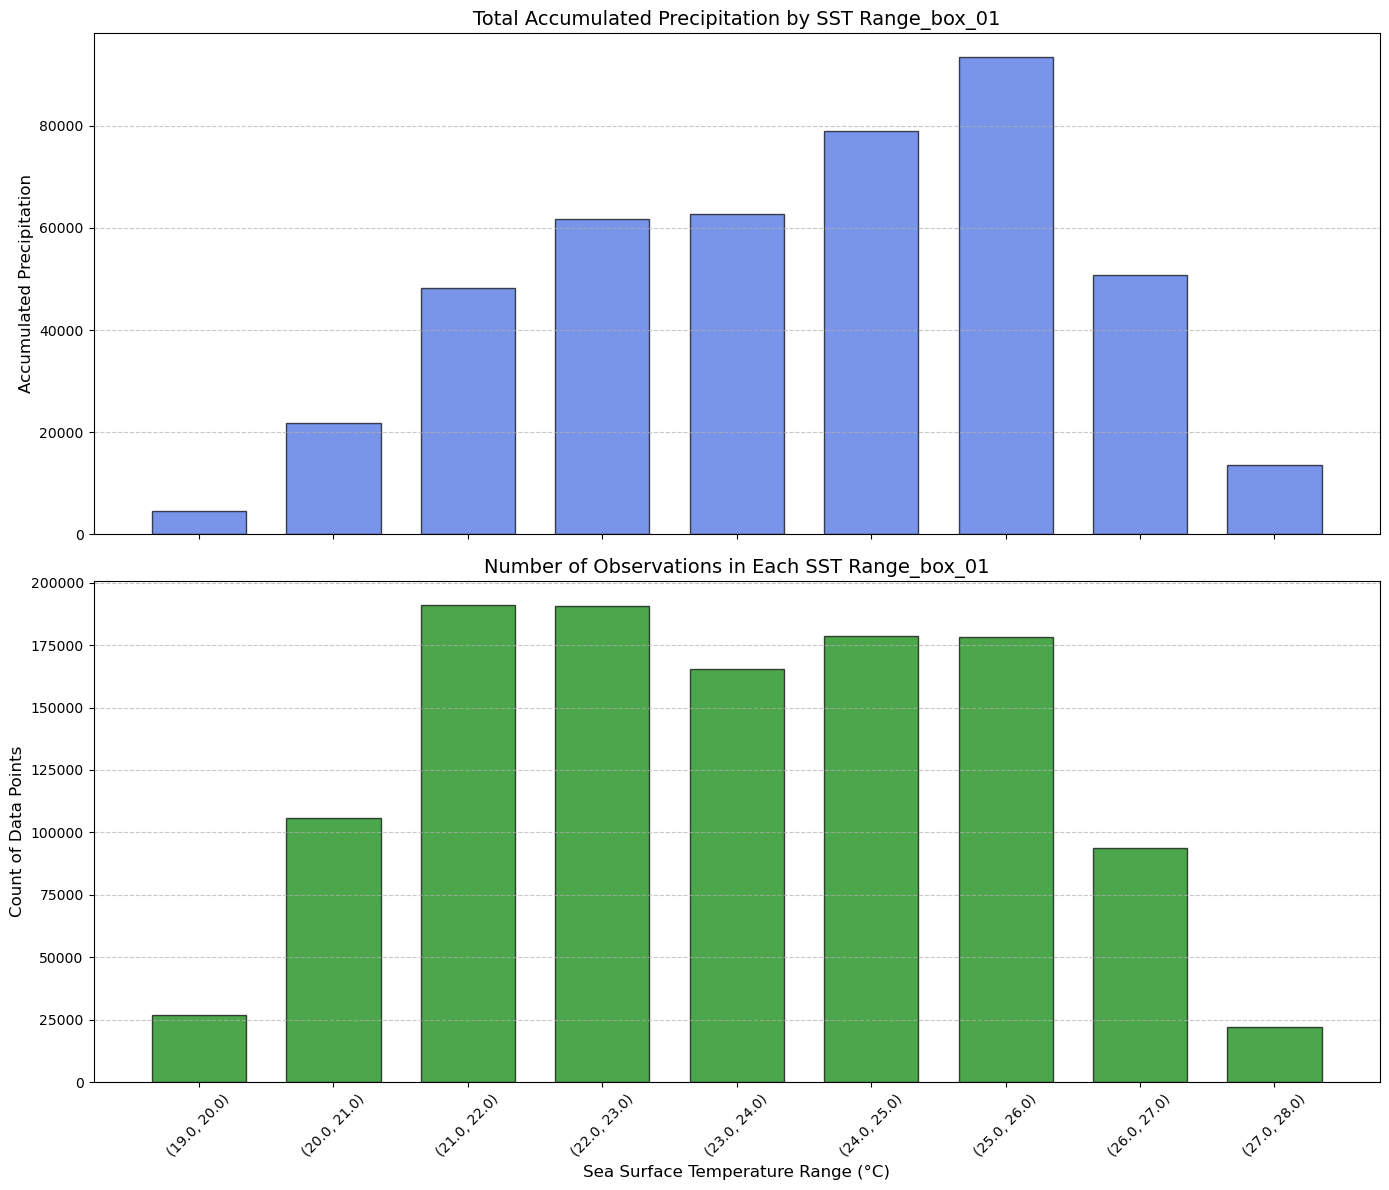

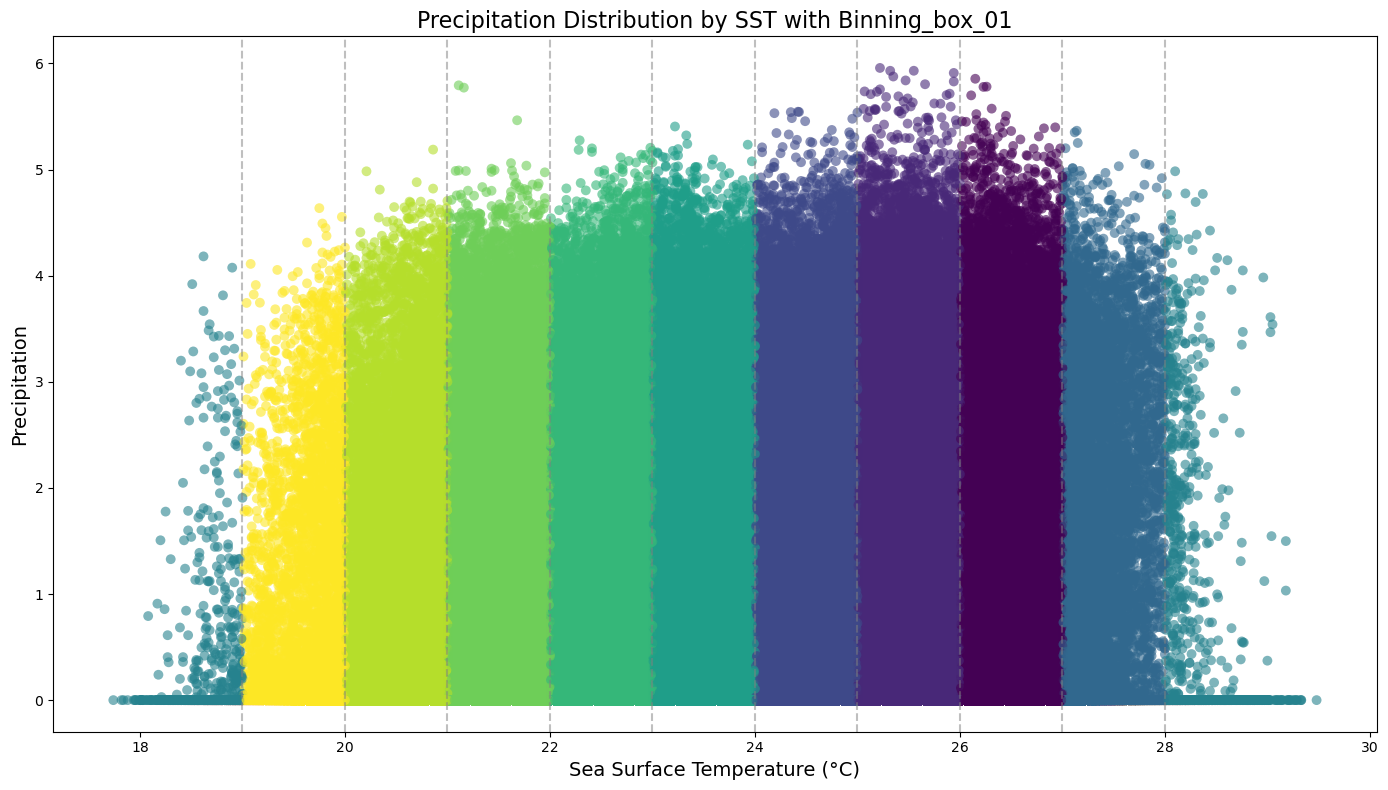

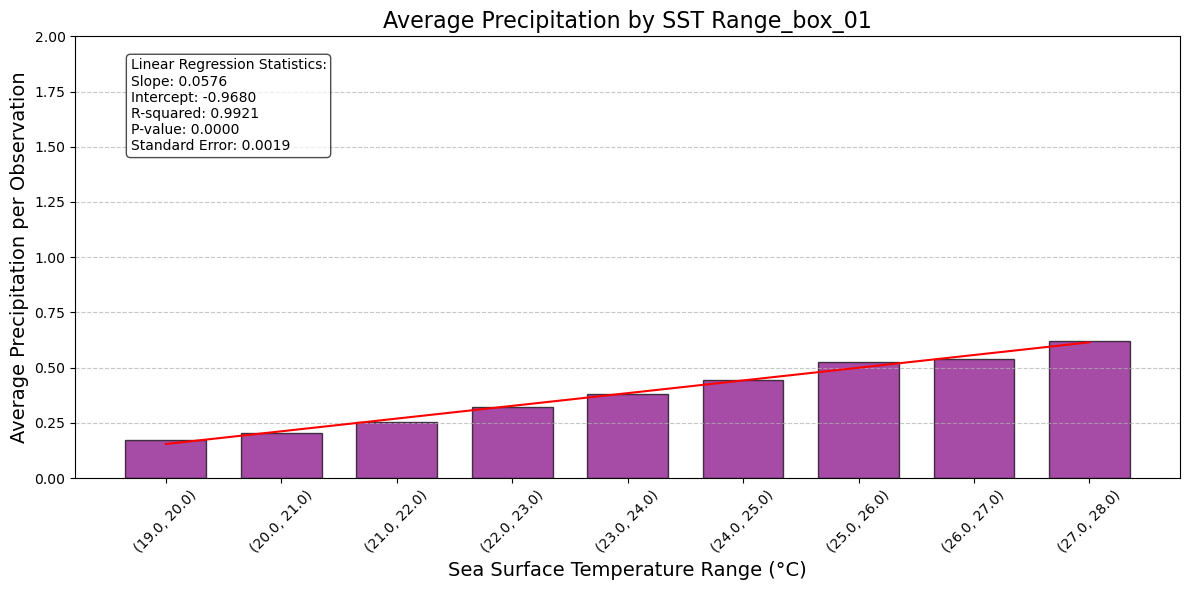

In [107]:
statistical_analysis_plot(data_box_01, accumulated_precip_box_01, sst_bins, 'box_01')

In [111]:
precip_box_02_values = precip_box_02.values.reshape(8034*12*12)

precip_box_02_values_log = np.log1p(precip_box_02_values)

sst_oisst_box_02_values = sst_oisst_box_02.values.reshape(8034*12*12)

data_box_02 = pd.DataFrame({'SST': sst_oisst_box_02_values, 'Precipitation': precip_box_02_values_log})

accumulated_precip_box_02, bin_labels, sst_bins = precip_accumulation_on_sst(data_box_02, 1, 19, 28)

Accumulated Precipitation by SST Bin:
        SST_bin  Precipitation  bin_midpoint
0  (19.0, 20.0)   24562.273290          19.5
1  (20.0, 21.0)   43918.995196          20.5
2  (21.0, 22.0)   53624.657927          21.5
3  (22.0, 23.0)   62093.666807          22.5
4  (23.0, 24.0)  115012.400255          23.5
5  (24.0, 25.0)  121533.925362          24.5
6  (25.0, 26.0)   67641.970449          25.5
7  (26.0, 27.0)    8846.054235          26.5


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/1117865337.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()


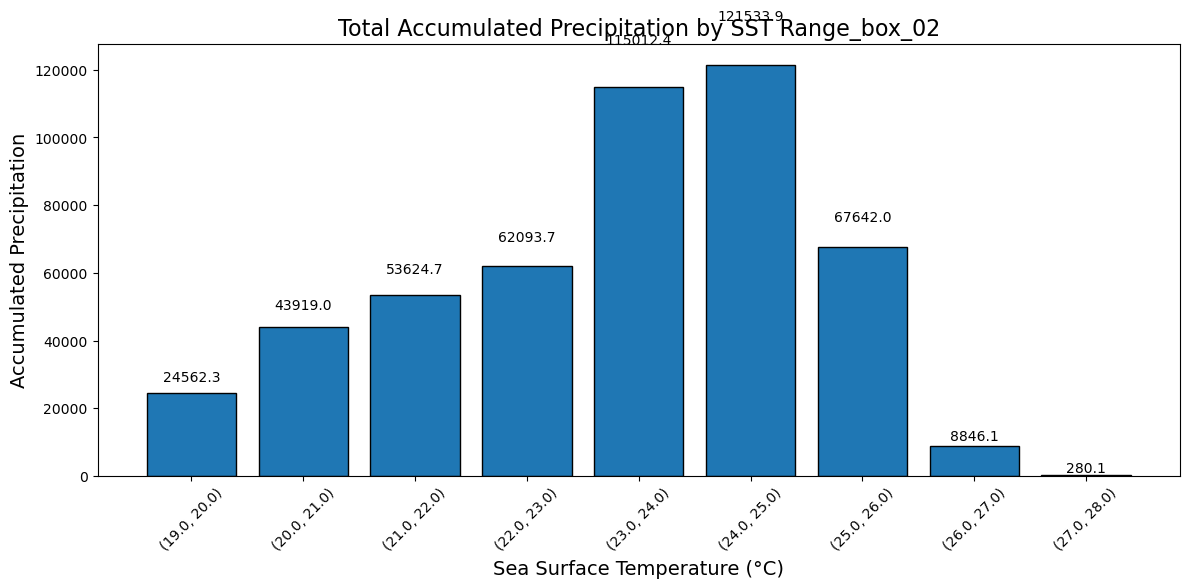

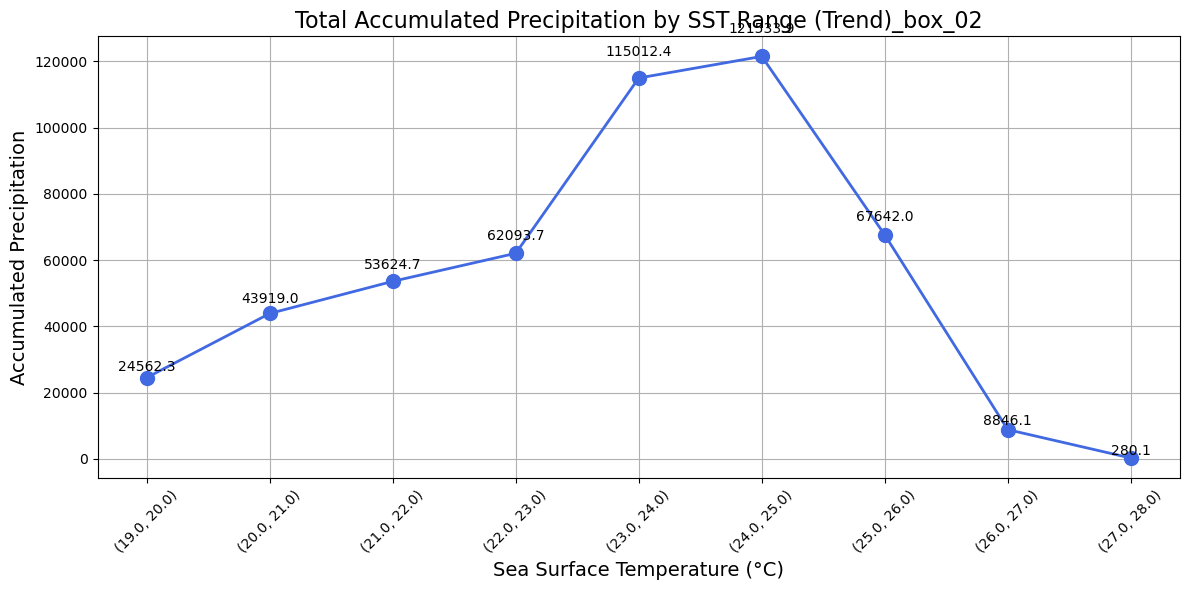

In [109]:
bar_plot(accumulated_precip_box_02, bin_labels, 'box_02')


Detailed Statistics for Each SST Bin:
        SST_bin            sum      mean   count       max       std
0  (19.0, 20.0)   24562.273290  0.177605  138297  6.279740  0.544409
1  (20.0, 21.0)   43918.995196  0.212018  207147  6.022842  0.613613
2  (21.0, 22.0)   53624.657927  0.292483  183343  6.055870  0.712890
3  (22.0, 23.0)   62093.666807  0.387287  160330  5.554044  0.800355
4  (23.0, 24.0)  115012.400255  0.613154  187575  6.944020  1.012309
5  (24.0, 25.0)  121533.925362  0.729167  166675  6.160975  1.119099
6  (25.0, 26.0)   67641.970449  0.802529   84286  5.886465  1.160267
7  (26.0, 27.0)    8846.054235  0.728490   12143  5.358801  1.063246


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/3989876577.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/3989876577.py:2: FutureWarning: The provided callable <function std at 0x104b28040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/3989876577.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bin_

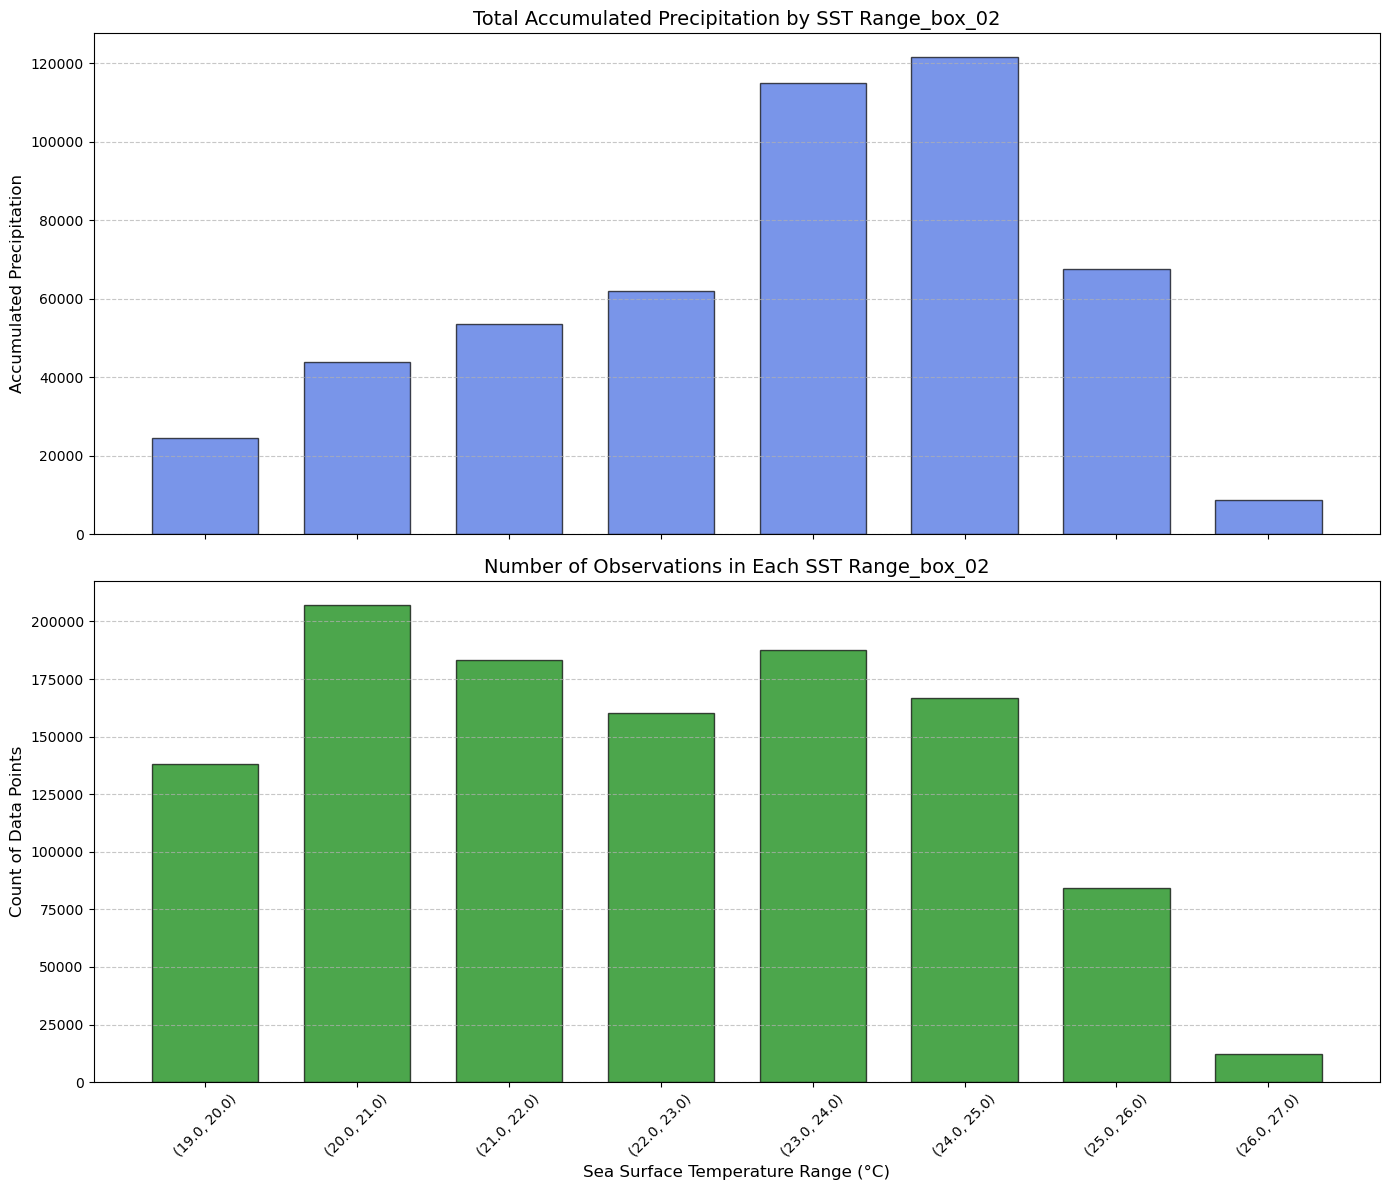

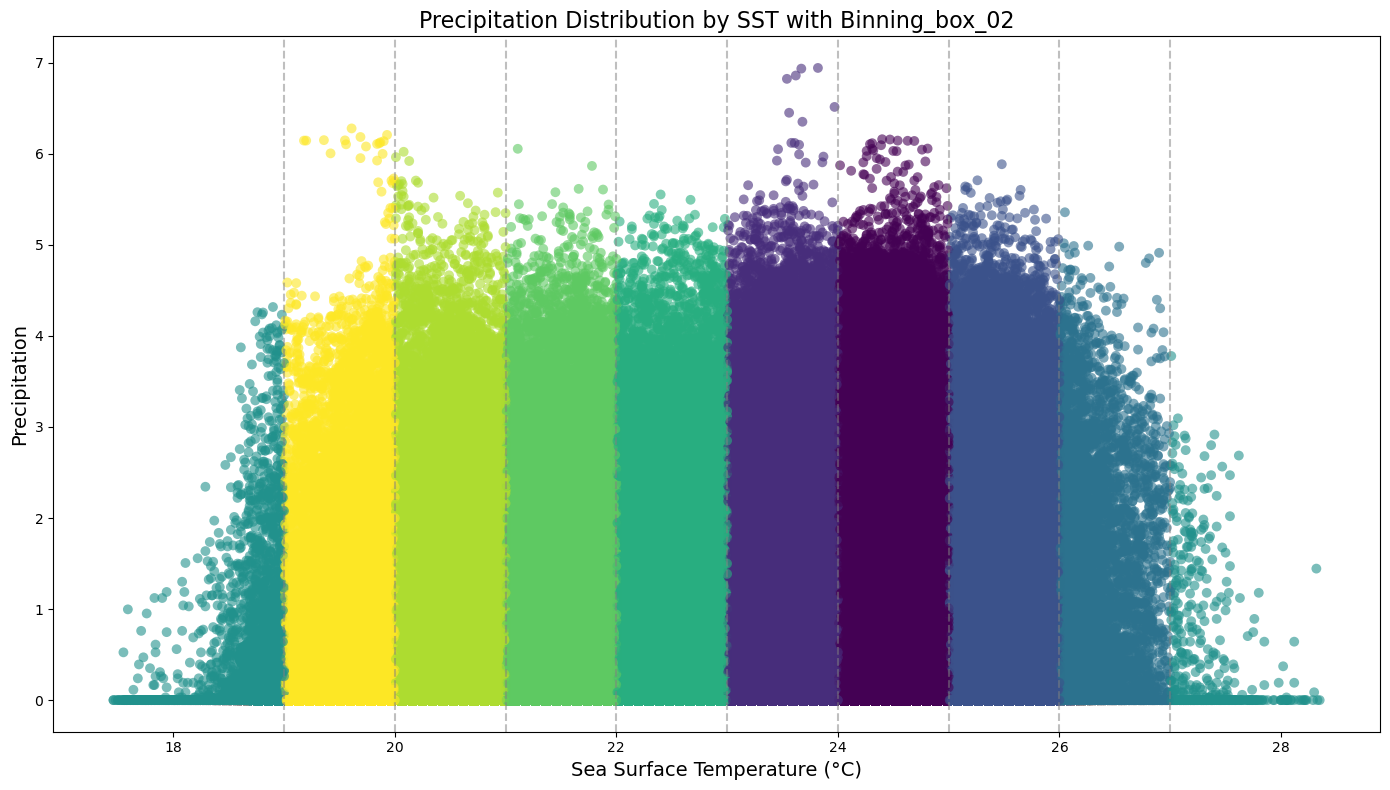

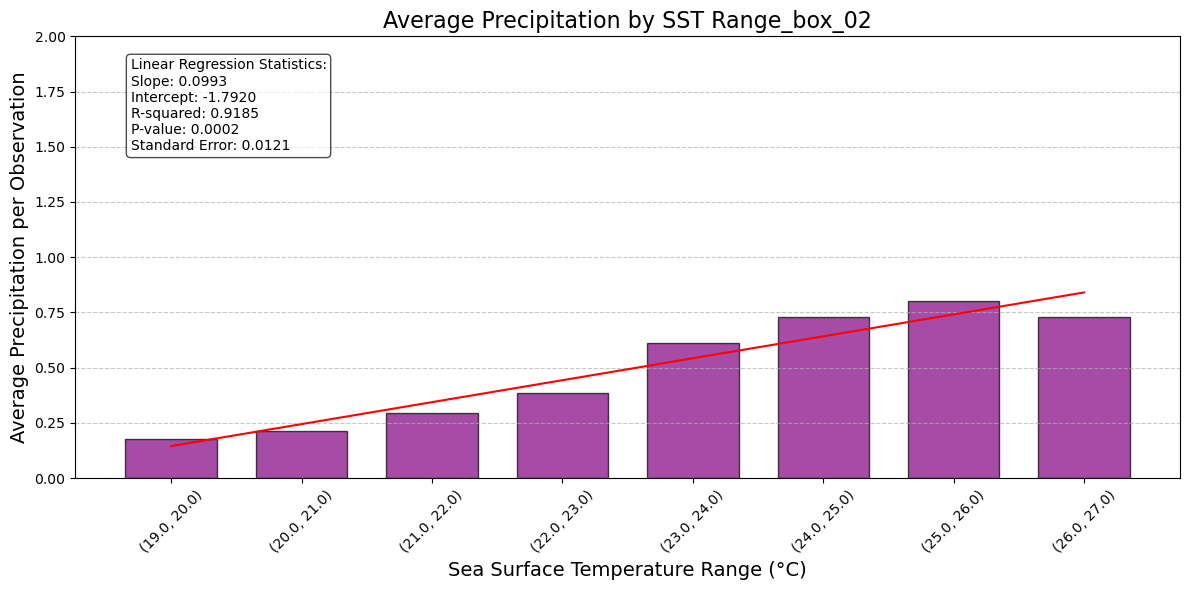

In [112]:
statistical_analysis_plot(data_box_02, accumulated_precip_box_02, sst_bins, 'box_02')

In [113]:
precip_box_03_values = precip_box_03.values.reshape(8034*12*12)

precip_box_03_values_log = np.log1p(precip_box_03_values)

sst_oisst_box_03_values = sst_oisst_box_03.values.reshape(8034*12*12)

data_box_03 = pd.DataFrame({'SST': sst_oisst_box_03_values, 'Precipitation': precip_box_03_values_log})

accumulated_precip_box_03, bin_labels, sst_bins = precip_accumulation_on_sst(data_box_03, 1, 19, 28)

Accumulated Precipitation by SST Bin:
        SST_bin  Precipitation  bin_midpoint
0  (19.0, 20.0)   98183.621146          19.5
1  (20.0, 21.0)  140900.555653          20.5
2  (21.0, 22.0)  127416.514282          21.5
3  (22.0, 23.0)  166164.598701          22.5
4  (23.0, 24.0)  194914.578079          23.5
5  (24.0, 25.0)  142899.756457          24.5
6  (25.0, 26.0)   49297.477976          25.5
7  (26.0, 27.0)    6923.657105          26.5


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/1117865337.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accumulated_precip = data.groupby('SST_bin')['Precipitation'].sum().reset_index()


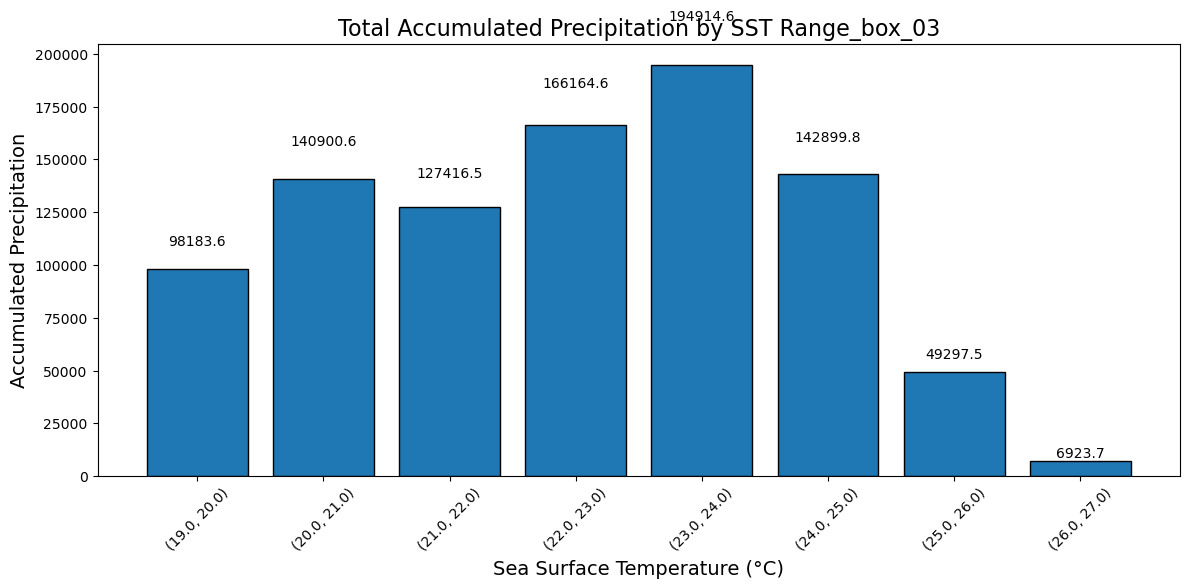

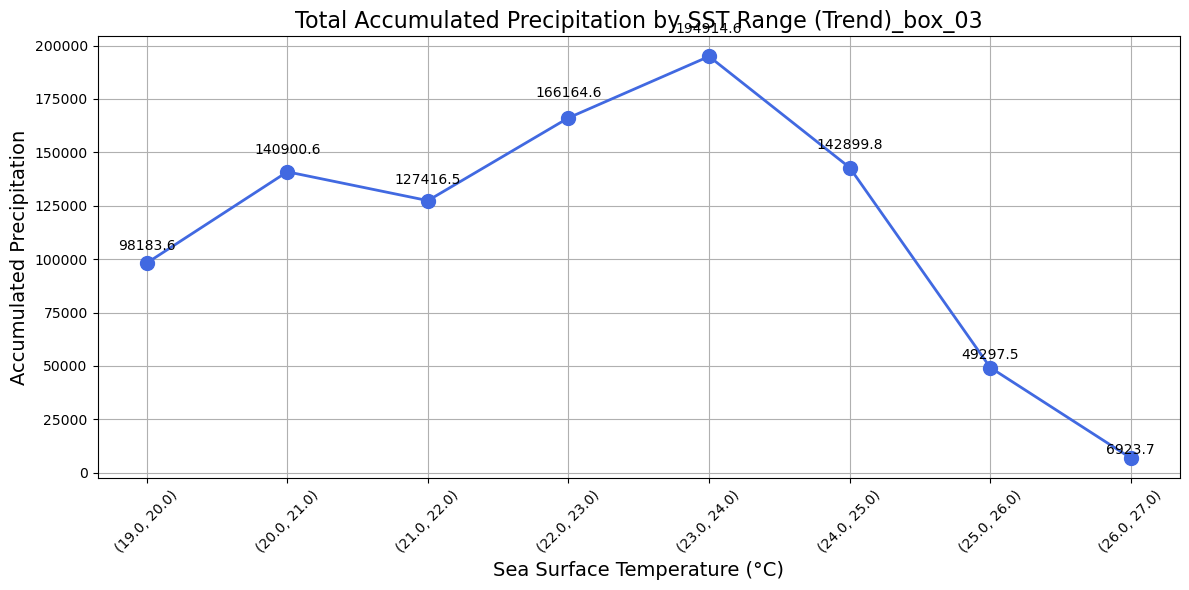

In [114]:
bar_plot(accumulated_precip_box_03, bin_labels, 'box_03')


Detailed Statistics for Each SST Bin:
        SST_bin            sum      mean   count       max       std
0  (19.0, 20.0)   98183.621146  0.539236  182079  5.849728  0.938705
1  (20.0, 21.0)  140900.555653  0.666922  211270  5.461784  1.037295
2  (21.0, 22.0)  127416.514282  0.770172  165439  5.480055  1.095647
3  (22.0, 23.0)  166164.598701  0.938195  177111  5.636395  1.182752
4  (23.0, 24.0)  194914.578079  1.114396  174906  6.071915  1.264518
5  (24.0, 25.0)  142899.756457  1.127548  126735  5.628017  1.262529
6  (25.0, 26.0)   49297.477976  1.222019   40341  5.246076  1.289651
7  (26.0, 27.0)    6923.657105  1.412991    4900  4.932746  1.292547


/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/3989876577.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/3989876577.py:2: FutureWarning: The provided callable <function std at 0x104b28040> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  bin_stats = data.groupby('SST_bin')['Precipitation'].agg([
/var/folders/fq/rybkyqtj5q5b4fdz5hwvtt680000gn/T/ipykernel_16129/3989876577.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(bin_

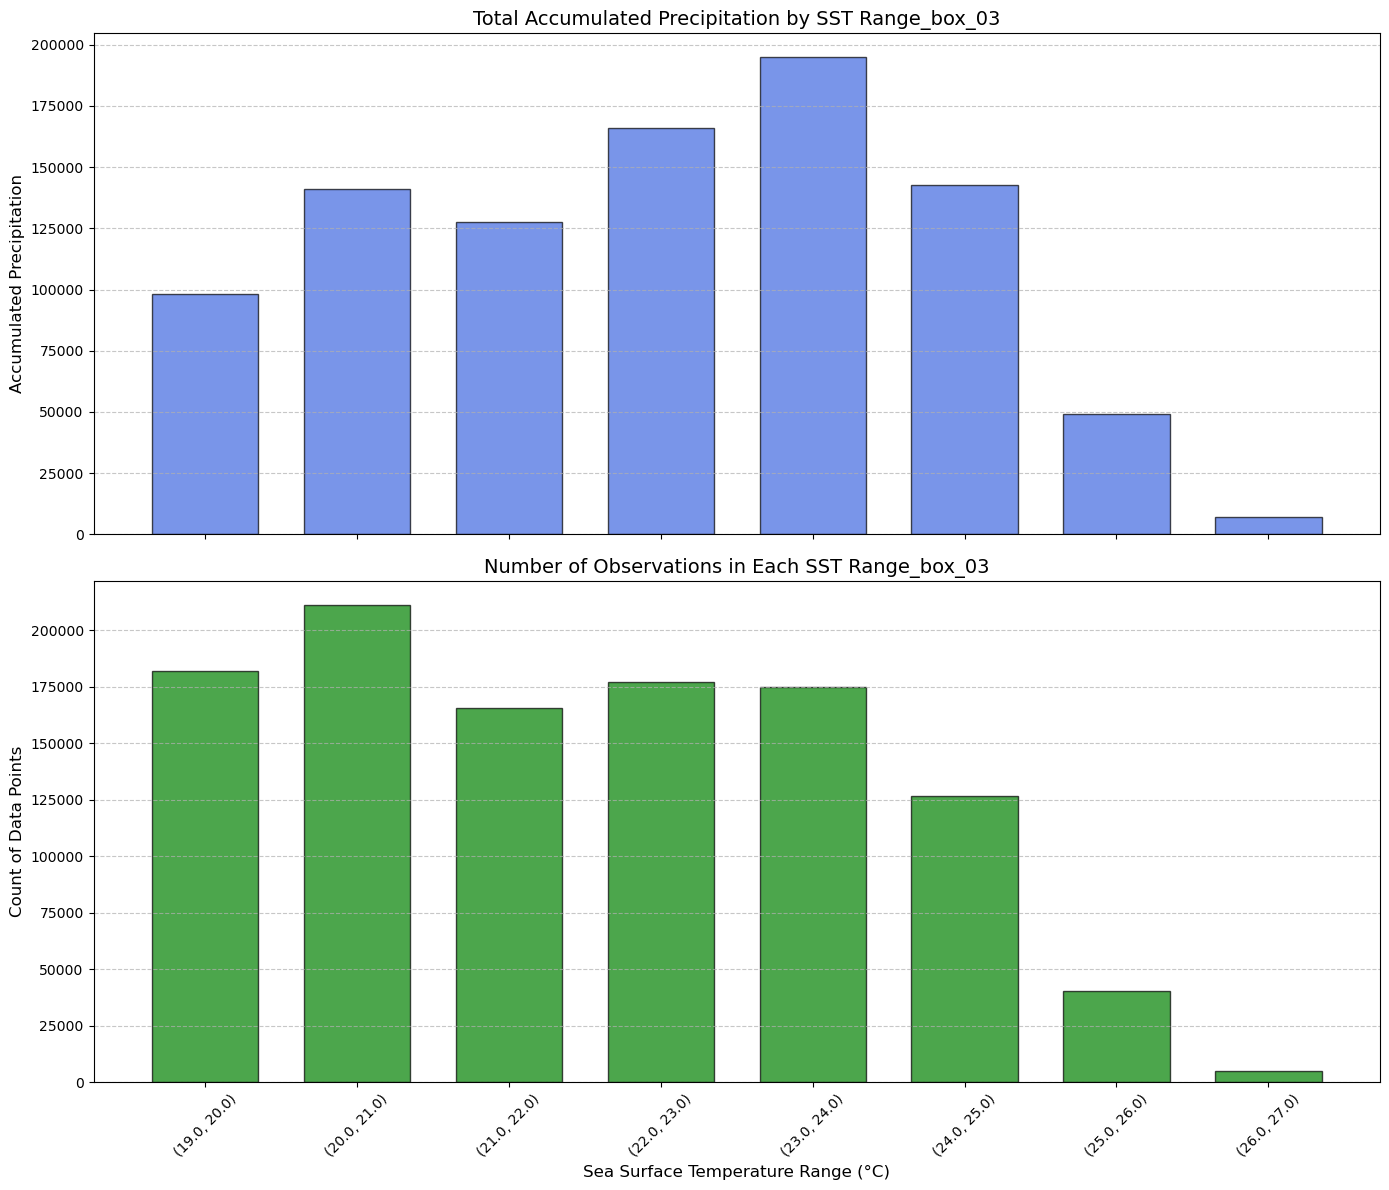

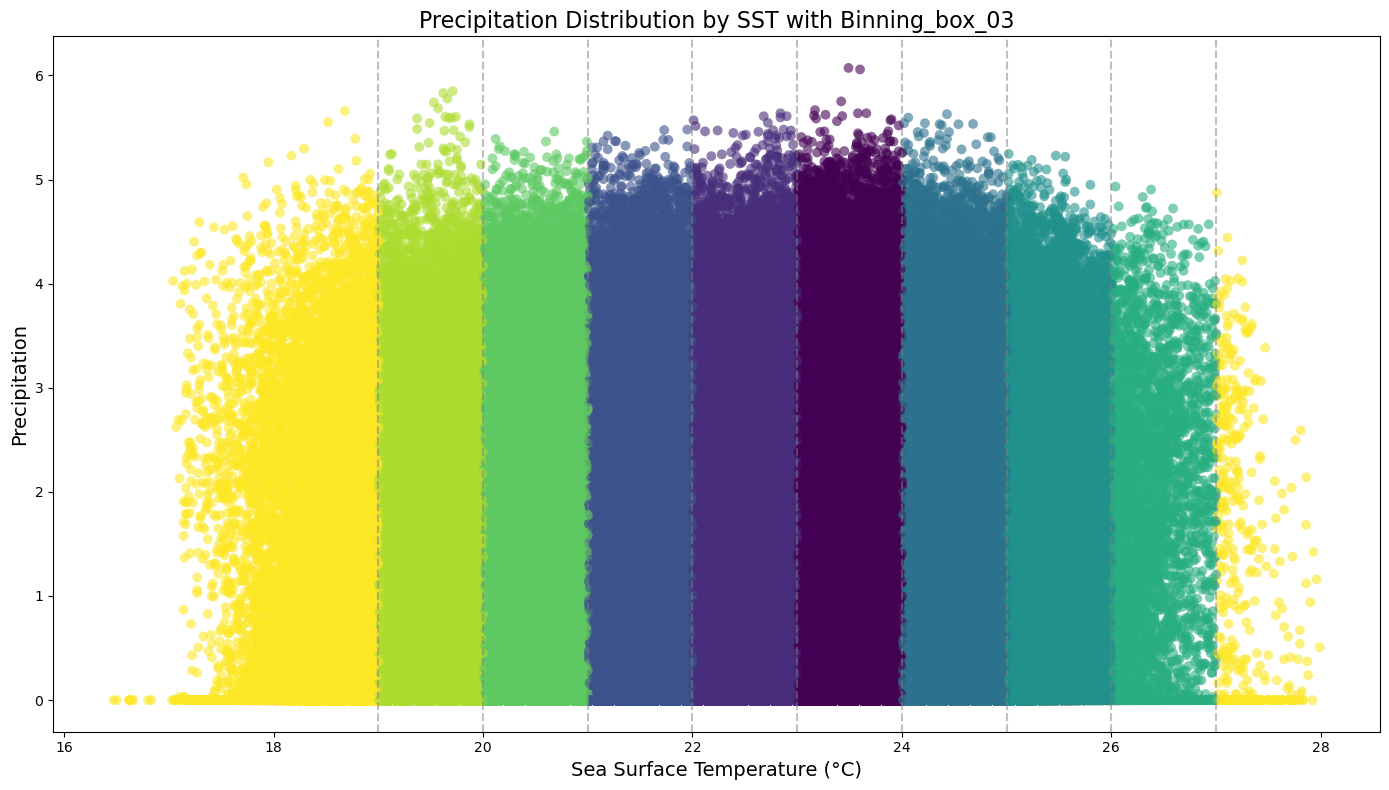

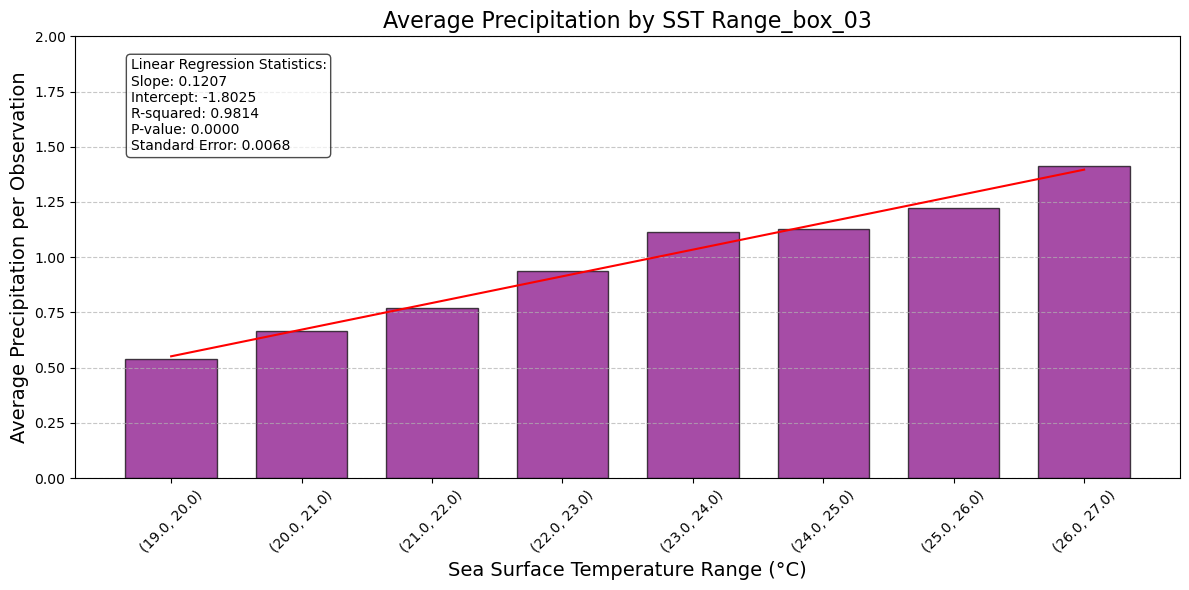

In [115]:
statistical_analysis_plot(data_box_03, accumulated_precip_box_03, sst_bins, 'box_03')